# ***The Final Project in the course: Hull-White Model***
***by Daria Wielgosz & Aleksander Lorenc, Summer 2023***


##**The title of the project:**

*Put and Call Stock Option Pricing in the Hull-White Model*



##**The plan of the project:**

In both   *PART I*   and *PART II* we use the same formulas, but for artificial and historical data sets, respectively. As historical data set we use stock prices for Microsoft in the year 2019.

**The formulas are following:**

**1)** For some stock prices $S(t_0), \dots, S(t_n)$, we estimate  parameter $\sigma_1$ for the Black-Scholes Model with the following formula:

$\sigma_1 =\Big(\frac{1}{T}\sum_{i=0}^{n-1} \big(\ln{\dfrac{S(t_{i+1})}{S(t_i)}}\big)^2\Big)^{\frac{1}{2}}$



**2)** For some interest rate values $r_{t_0}, \dots, r_{t_n}$, we estimate  parameters $\sigma_2$ and $a$ for the Hull-White Model with the following formulas:

$a = \frac{1}{h} \ln{\dfrac{\sum_{k=0}^{n-1} r_k^2}{\sum_{k=0}^{n-1} r_k r_{k+1}}}$

$\sigma_2 = \Big(\frac{2a}{n(1-e^{-2ah})}\sum_{k=0}^{n-1}(r_{k+1}-e^{-ah}r_k)^2\Big)^\frac{1}{2}$




**3)** With the Euler–Maruyama method and using estimated parameters we simulate $N$ trajectories of future stock prices and interest rates in chosen time frame $[t_n,T]$ where:

$dr_t = -ar_t dt + \sigma_2 dW_{t}, t \in [t_n, T]$
    
$dS(t) = r_{t}S(t)dt + \sigma_1S(t)dW_{t}, t \in [t_n, T]$



**4)** Having simulated a number of trajectories we price stock options with following formulas:

$Put = \mathbb{E}_{\mathbb{Q}}(e^{-\int_{t_n}^{T} r_s \,ds}(K-S_T)^+)) \thickapprox \frac{1}{N} \sum_{j=1}^{N}(e^{-\sum_{i=t_n}^{T-1} r_i(w_j)*h}(K-S_T(w_j))^+)$

$Call = \mathbb{E}_{\mathbb{Q}}(e^{-\int_{t_n}^{T} r_s \,ds}(S_T-K)^+)) \thickapprox \frac{1}{N} \sum_{j=1}^{N}(e^{-\sum_{i=t_n}^{T-1} r_i(w_j)*h}(S_T(w_j)-K)^+)$




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, exp
from tabulate import tabulate
import scipy.stats as scs
import statsmodels.api as sm

# Part 1: Pricing oprion based on simulated data sets.

##Creating one trajectory of stock prices and stochastic interest rate.

$$dr_t = -ar_t dt + \sigma_2 dW_{t}, t \in [0, T]$$
$$dS(t) = r_{t}S(t)dt + \sigma_1S(t)dW_{t}, t \in [0, T]$$

In [ ]:
T1 = 5 # range of time horizon in years
N = 50000 # number of points in time
a1=1.1
sigma11=0.01
sigma21=0.01

K = 103 #strike price

In [ ]:
def euler_maruyama(seed, T, N, S0, sigma1, r0, a, sigma2):
        np.random.seed(seed)
        dt = T / N
        square = np.sqrt(dt)
        t = [dt * i for i in range(N + 1)]
        stock_prices = np.zeros(N + 1)
        interest_rates = np.zeros(N + 1)

        stock_prices[0] = S0
        interest_rates[0] = r0
        z = np.random.normal(0,1,N)

        for i in range(N):
            interest_rates[i + 1] = interest_rates[i] - a*interest_rates[i]*dt + sigma2*square*z[i]
            stock_prices[i + 1] = stock_prices[i] + interest_rates[i]*stock_prices[i]*dt + sigma1*stock_prices[i]*square*z[i]
        return [t , stock_prices, interest_rates]


In [ ]:
time, Sym_stock_prices, Sym_interest_rates = euler_maruyama(seed = 456, T = T1, N = N, S0 = 100, sigma1 = sigma11, r0 = 0.03, a = a1, sigma2 = sigma21)

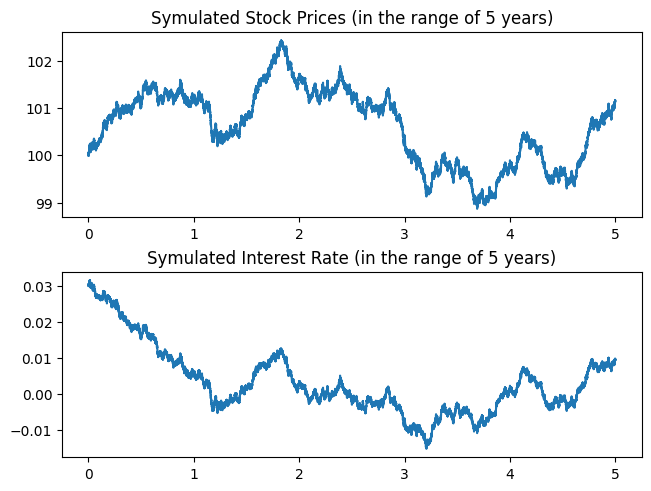

In [ ]:
fig, axis = plt.subplots(2, 1, constrained_layout=True)
axis[0].plot(time, Sym_stock_prices)
axis[0].set_title("Symulated Stock Prices (in the range of "+str(T1)+" years)")
axis[1].plot(time, Sym_interest_rates)
axis[1].set_title("Symulated Interest Rate (in the range of "+str(T1)+" years)")
plt.show()

## Estimating parameters

$$\sigma_1 = (\frac{1}{T}\sum_{i=0}^{N-1} (\ln{\dfrac{S(t_{i+1})}{S(t_i)}})^2)^{\frac{1}{2}}$$
$$a = \frac{1}{h} \ln{\dfrac{\sum_{k=0}^{N-1} r_k^2}{\sum_{k=0}^{N-1} r_k r_{k+1}}}$$
$$\sigma_2 = \Big(\frac{2a}{N(1-e^{-2ah})}\sum_{k=0}^{N-1}(r_{k+1}-e^{-ah}r_k)^2\Big)^{\frac{1}{2}}$$


In [ ]:
def sigma1_estimation(stock_prices, N, T):
  sum = 0;
  for i in range(0,N):
    log_return = np.log(stock_prices[i+1]/stock_prices[i])
    sum = sum + np.power(log_return,2)
  sigma1 = np.sqrt(sum)*np.sqrt(1/T)
  return sigma1

In [ ]:
def a_estimation(interest_rates, N, T):
  h=T/N
  sum1 = 0
  sum2 = 0
  for i in range(0,N):
    sum1 = sum1 + np.power(interest_rates[i],2)
    sum2 = sum2 + interest_rates[i]*interest_rates[i+1]
  a = (1/h) * np.log(sum1/sum2)
  return a

In [ ]:
def sigma2_estimation(interest_rates, a, N, T):
  h = T/N
  sum3 = 0
  for i in range(0,N):
    sum3 = sum3 + np.power(interest_rates[i+1] - np.exp(-a*h)*interest_rates[i], 2)
  sigma2 = np.sqrt((2*a*sum3)/(N*(1-exp(-2*a*h))))
  return sigma2

In [ ]:
est_sigma1 = sigma1_estimation(Sym_stock_prices, N, T1)
est_a = a_estimation(Sym_interest_rates, N, T1)
est_sigma2 = sigma2_estimation(Sym_interest_rates, est_a, N, T1)

In [ ]:
table = [['Parameter', 'Originally choosen parameter', 'Estimated parameter', 'Rounded difference'],
         ['sigma1', sigma11, est_sigma1, np.round(sigma11-est_sigma1, 6)],
         ['a', a1, est_a, np.round(a1-est_a, 6)],
         ['sigma2', sigma21, est_sigma2, np.round(sigma21-est_sigma2, 6)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤════════════════════════════════╤═══════════════════════╤══════════════════════╕
│ Parameter   │   Originally choosen parameter │   Estimated parameter │   Rounded difference │
╞═════════════╪════════════════════════════════╪═══════════════════════╪══════════════════════╡
│ sigma1      │                           0.01 │             0.0100578 │            -5.8e-05  │
├─────────────┼────────────────────────────────┼───────────────────────┼──────────────────────┤
│ a           │                           1.1  │             1.36848   │            -0.268478 │
├─────────────┼────────────────────────────────┼───────────────────────┼──────────────────────┤
│ sigma2      │                           0.01 │             0.0100582 │            -5.8e-05  │
╘═════════════╧════════════════════════════════╧═══════════════════════╧══════════════════════╛


Since the rounded difference given above is relatively small, we find our functions well defined.

##Using estimated parameters for simulating future trajectories

In [ ]:
T2=3
N2=30000
NOS=10000 # Number of Simulations
S_start = Sym_stock_prices[-1]
r_start = Sym_interest_rates[-1]


In [ ]:
def Future_symulations(seed, number_of_simulations, T, N, S0, sigma1, r0, a, sigma2):
    np.random.seed(seed)
    dt = T / N
    square = np.sqrt(dt)
    z = np.random.normal(size=(number_of_simulations, N))

    stock_prices = np.zeros((number_of_simulations, N + 1))
    interest_rates = np.zeros((number_of_simulations, N + 1))
    stock_prices[:, 0] = S0
    interest_rates[:, 0] = r0

    for i in range(N):
        interest_rates[:, i + 1] = interest_rates[:, i] - a*interest_rates[:, i]*dt + sigma2*square*z[:, i]
        stock_prices[:, i + 1] = stock_prices[:, i] + interest_rates[:, i]*stock_prices[:, i]*dt + sigma1*stock_prices[:, i]*square*z[:, i]

    t = np.array([dt * i for i in range(N + 1)])
    return stock_prices, interest_rates, t


In [ ]:
Future_stock_prices1, Future_interest_rates1, FsTime = Future_symulations(10, number_of_simulations = NOS, T = T2, N = N2, S0 = S_start, sigma1 = est_sigma1,
                                                           r0 = r_start, a = est_a, sigma2 = est_sigma1)

(the above line of code executes in around 75 seconds)

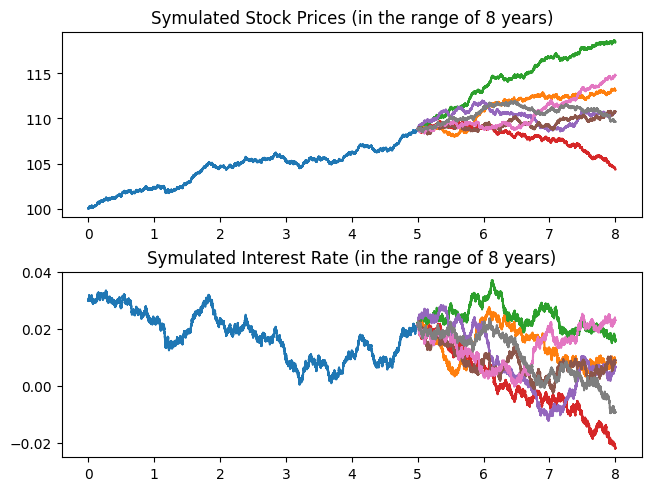

In [ ]:
# we need to choose how many simulations to plot
how_many = 7

new_time = [FsTime[i]+T1 for i in range(len(FsTime))]
fig, axis = plt.subplots(2, 1, constrained_layout=True)
axis[0].plot(time, Sym_stock_prices)
for i in range(0,how_many):
  axis[0].plot(new_time, Future_stock_prices1[i,:])
axis[0].set_title("Symulated Stock Prices (in the range of " +str(T1+T2)+ " years)")
axis[1].plot(time, Sym_interest_rates)
for i in range(0,how_many):
  axis[1].plot(new_time, Future_interest_rates1[i,:])
axis[1].set_title("Symulated Interest Rate (in the range of " +str(T1+T2)+ " years)")
plt.show()

## Pricing the options and checking their convergence depending on the number of trajectories

$$Put = \mathbb{E}_{\mathbb{Q}}(e^{-\int_{t_n}^{T} r_s \,ds}(K-S_T)^+)) \thickapprox \frac{1}{N} \sum_{j=1}^{N}(e^{-\sum_{i=t_n}^{T-1} r_i(w_j)*h}(K-S_T(w_j))^+)$$

$$Call = \mathbb{E}_{\mathbb{Q}}(e^{-\int_{t_n}^{T} r_s \,ds}(S_T-K)^+)) \thickapprox \frac{1}{N} \sum_{j=1}^{N}(e^{-\sum_{i=t_n}^{T-1} r_i(w_j)*h}(S_T(w_j)-K)^+)$$

In [ ]:
def put_payoffs(K, last_stock_prices):
  return np.maximum(0, K - last_stock_prices)

In [ ]:
def call_payoffs(K, last_stock_prices):
  return np.maximum(0, last_stock_prices - K)

In [ ]:
def integral_approx(all_interest_rates, T, N):
  h=T/N
  return h * np.sum(all_interest_rates, axis=1)

In [ ]:
def put_price(last_stock_prices, all_interest_rates, T, N, K):
  h=T/N
  puts = put_payoffs(K, last_stock_prices)
  integ_appr = integral_approx(all_interest_rates, T, N)
  ah = np.exp(-1*integ_appr)*puts
  price = np.mean(ah)
  return price

In [ ]:
S_T = Future_stock_prices1[:,-1]
PutPrice = put_price(S_T, Future_interest_rates1, T2, N2, K)
PutPrice

0.005180458857177675

In [ ]:
def Put_Price_vs_number_of_traj_plot(last_stock_prices, all_interest_rates, T, N, K):
  h = T/N
  w = all_interest_rates.shape[0]
  puts = put_payoffs(K, last_stock_prices)
  integral_approx = h * np.sum(all_interest_rates, axis=1)
  Put_Price_plot = np.zeros(w)
  for i in range(w):
    Put_Price_plot[i] = np.mean(np.exp(-1*integral_approx[0:i+1]) * puts[0:i+1])

  plt.plot(range(1,w+1), Put_Price_plot)
  plt.title("Put Price dep. on number of traj. used in sym.")
  return plt.show()

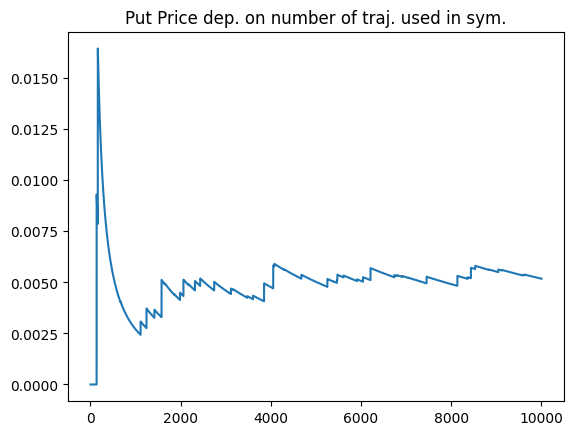

In [ ]:
Put_Price_vs_number_of_traj_plot(S_T, Future_interest_rates1, T2, N2, K)

As the number of trajectories increases, the price fluctuates less.

In [ ]:
def call_price(last_stock_prices, all_interest_rates, T, N, K):
  h=T/N
  calls = call_payoffs(K, last_stock_prices)
  integ_appr = integral_approx(all_interest_rates, T, N)
  ah = np.exp(-1*integ_appr)*calls
  price = np.mean(ah)
  return price

In [ ]:
CallPrice = call_price(S_T, Future_interest_rates1, T2, N2, K)
CallPrice

10.554915484954947

In [ ]:
def Call_Price_vs_number_of_traj_plot(last_stock_prices, all_interest_rates, T, N, K):
  h = T/N
  w = all_interest_rates.shape[0]
  calls = call_payoffs(K, last_stock_prices)
  integral_approx = h * np.sum(all_interest_rates, axis=1)
  Call_Price_plot = np.zeros(w)
  for i in range(w):
    Call_Price_plot[i] = np.mean(np.exp(-1*integral_approx[0:i+1]) * calls[0:i+1])

  plt.plot(range(1001,w+1), Call_Price_plot[1000:])
  plt.title("Call Price dep. on number of traj. used in sym.")
  return plt.show()

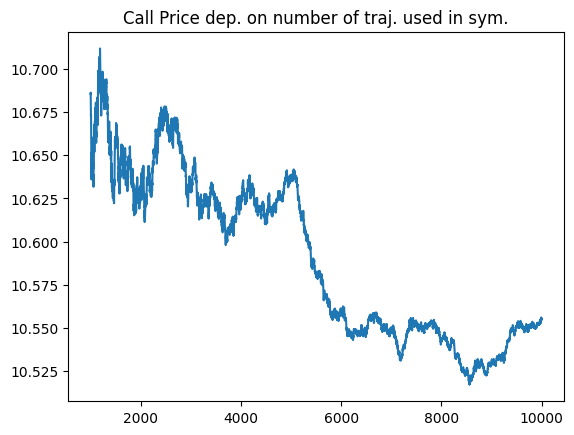

In [ ]:
Call_Price_vs_number_of_traj_plot(S_T, Future_interest_rates1, T2, N2, K)

Unfortunately, as the number of trajectories increases, the price still fluctuates, however only with amplitude of 0.2 unit of currency.

In [ ]:
table = [['Option', 'Estimated price for all traj.'],
         ['PUT', PutPrice],
         ['CALL', CallPrice]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═════════════════════════════════╕
│ Option   │   Estimated price for all traj. │
╞══════════╪═════════════════════════════════╡
│ PUT      │                      0.00518046 │
├──────────┼─────────────────────────────────┤
│ CALL     │                     10.5549     │
╘══════════╧═════════════════════════════════╛


#Part 2: Historical Stock Prices of Microsoft in 2019
##(Data set downloaded from Nasdaq)


In [ ]:
# memory cleaning
del Future_stock_prices1, Future_interest_rates1, FsTime

In [ ]:
PLIK=pd.read_csv('/content/MSFT.csv')

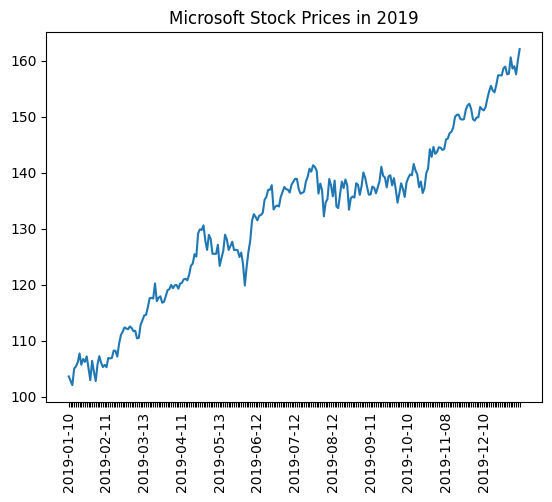

In [ ]:
df=PLIK[["Date", "Close"]]
start=df[df['Date']=="2019-01-10"].index.values.astype(int)
start=start[0]
end=start+252
data=df["Close"][start:end]
dates=df["Date"][start:end]
dates=dates.reset_index(drop=True)
Allx=list(dates)
labels = []
for i in range(len(Allx)):
  if i % 21 == 0:
    labels.append(Allx[i])
  else:
    labels.append("")
plt.plot(dates,data)
plt.title("Microsoft Stock Prices in 2019")
plt.xticks(ticks=dates,labels=labels, rotation='vertical')
plt.show()

Now we will check if the data set satisfies the normality assumptions of the Black-Scholes Model

In [ ]:
#Making list of daily logaritmic rates of return, i.e. ln(S(t_i)/ S(t_{i-1}))

def daily_return(adj_close):
    returns = []
    for i in range(0, len(adj_close)-1):
        today = adj_close[i+1]
        yesterday = adj_close[i]
        daily_return = np.log(today / yesterday)
        returns.append(daily_return)
    return returns

In [ ]:
returns = daily_return(np.array(data))

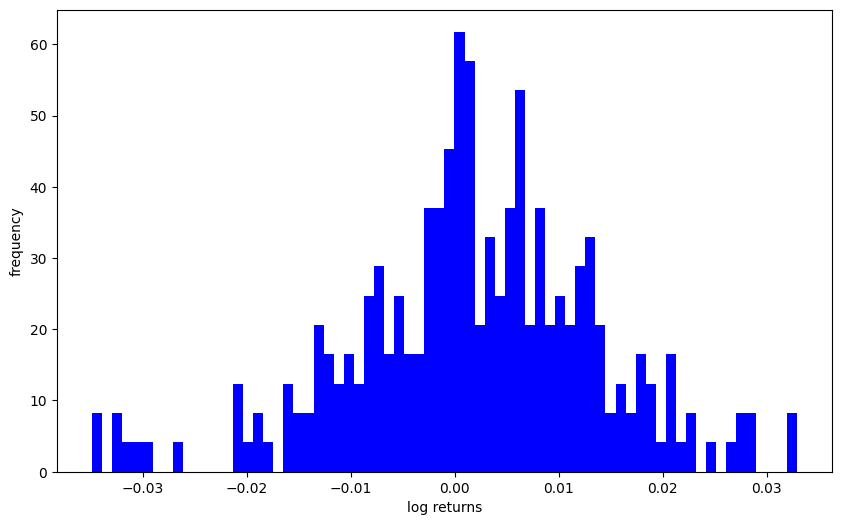

In [ ]:
#PLOTTING THE HISTOGRAM
log_ret = np.asarray(returns)
plt.figure(figsize=(10,6))
plt.hist(log_ret.flatten(), bins=70, density=True, label='frequency', color='b')
plt.xlabel('log returns')
plt.ylabel('frequency')
x = np.linspace(plt.axis()[0], plt.axis()[1])
plt.show()

The plot above looks similar to the probability density of the Stdandard Normal Distribution, although we are aware we cannot rely only on the graph.

Normality test p-value       0.011225
Skewness                    -0.347482
Kurtosis test p-value        0.047895


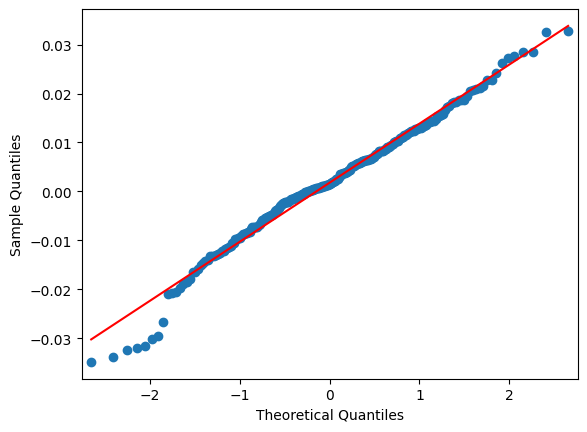

In [ ]:
#Statistical tests of: normality, skewness and kurtosis

def normality_test(arr):
    print('Normality test p-value %14f' % scs.normaltest(arr)[1])

def skewness_test(arr): #should be around 0 for standard normal distribution
    print('Skewness %28f' % scs.skew(arr))

def kurtosis_test(arr):
    print('Kurtosis test p-value %15f' % scs.kurtosistest(arr)[1])

normality_test(log_ret)
skewness_test(log_ret)
kurtosis_test(log_ret)
sm.qqplot(log_ret, line='s');

Although the Normality test p-value is smaller than 0.05, for our needs (and as for historical data) it is good enough.

In [ ]:
Interest_Rate = pd.read_excel('/content/IR.xlsx')

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
df2=Interest_Rate[["Effective Date", "Rate (%)"]]
start_IR=df2[df2['Effective Date']=="01/10/2019"].index.values.astype(int)
start_IR=start_IR[0]
end_IR=start_IR-252

data=df2["Rate (%)"][end_IR:start_IR]
data=data[::-1]
dates=df2["Effective Date"][end_IR:start_IR]
dates=dates[::-1]
IR_dates=dates.reset_index(drop=True)
IR=data.reset_index(drop=True)

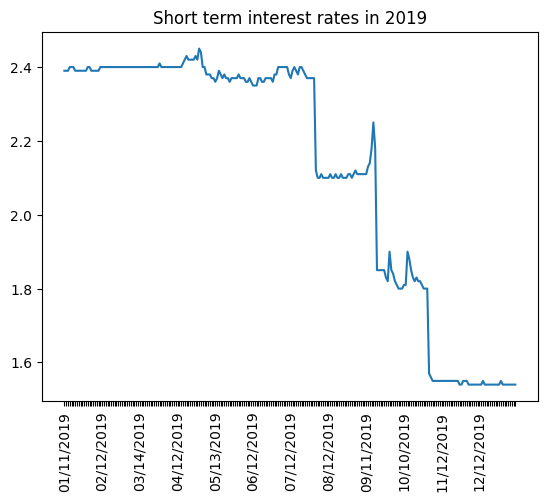

In [ ]:
Allx=list(IR_dates)
labels = []
for i in range(len(Allx)):
  if i % 21 == 0:
    labels.append(Allx[i])
  else:
    labels.append("")
plt.plot(IR_dates,IR)
plt.xticks(ticks=IR_dates,labels=labels, rotation='vertical')
plt.title("Short term interest rates in 2019")
plt.show()

##Parameters estimation

In [ ]:
# Since the historical stock prices oscylate around 160 $ in the final part of data set, for the further calculations we are setting the following strike
K=300

In [ ]:
Real_stock_prices = np.array(df["Close"][start:end])
Real_interest_rates = np.array(IR)
real_N = len(Real_stock_prices)
real_T1 = 1

In [ ]:
real_est_sigma1 = sigma1_estimation(Real_stock_prices, real_N-1, real_T1)
real_est_a = a_estimation(Real_interest_rates, real_N-1, real_T1)
real_est_sigma2 = sigma2_estimation(Real_interest_rates, real_est_a, real_N-1, real_T1)

In [ ]:
table = [['Parameter', 'Estimated parameter'],
         ['sigma1', real_est_sigma1],
         ['a', real_est_a],
         ['sigma2', real_est_sigma2]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤═══════════════════════╕
│ Parameter   │   Estimated parameter │
╞═════════════╪═══════════════════════╡
│ sigma1      │              0.193286 │
├─────────────┼───────────────────────┤
│ a           │              0.389449 │
├─────────────┼───────────────────────┤
│ sigma2      │              0.516251 │
╘═════════════╧═══════════════════════╛


In [ ]:
Real_S_start = Real_stock_prices[-1]
Real_r_start = Real_interest_rates[-1]
Real_NOS = 5000
Real_T2 = 0.5

In [ ]:
Real_Future_stock_prices1, Real_Future_interest_rates1, Real_FsTime = Future_symulations(123, number_of_simulations = Real_NOS, T = Real_T2, N = N2,
                                                                                         S0 = Real_S_start, sigma1 = real_est_sigma1,
                                                                                         r0 = Real_r_start, a = real_est_a, sigma2 = real_est_sigma1)

(the above line of code executes in around 45 seconds)

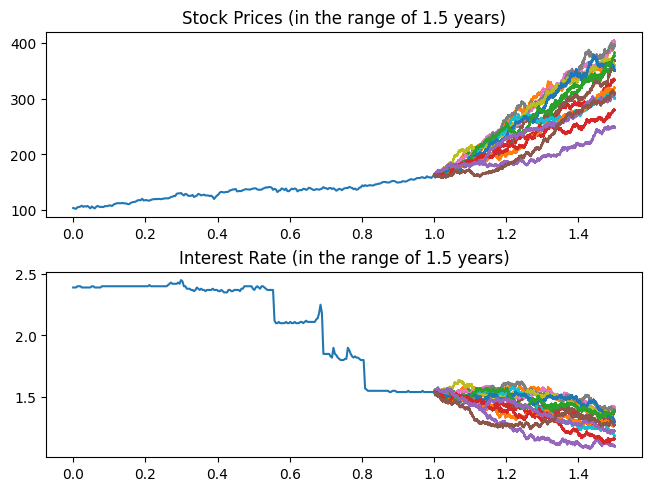

In [ ]:
# choose how many simulations to plot
real_how_many = 15
real_time = np.linspace(0, 1, 252)
real_new_time = [Real_FsTime[i]+real_T1 for i in range(len(Real_FsTime))]
fig, axis = plt.subplots(2, 1, constrained_layout=True)
axis[0].plot(real_time, Real_stock_prices)
for i in range(0,real_how_many):
  axis[0].plot(real_new_time, Real_Future_stock_prices1[i,:])
axis[0].set_title("Stock Prices (in the range of " +str(real_T1 + Real_T2)+ " years)")
axis[1].plot(real_time, Real_interest_rates)
for i in range(0,real_how_many):
  axis[1].plot(real_new_time, Real_Future_interest_rates1[i,:])
axis[1].set_title("Interest Rate (in the range of "+str(real_T1 + Real_T2)+" years)")
plt.show()

In [ ]:
Real_S_T = Real_Future_stock_prices1[:,-1]
PutPrice = put_price(Real_S_T, Real_Future_interest_rates1, Real_T2, Real_NOS, K)
PutPrice

0.212985808495325

In [ ]:
CallPrice = call_price(Real_S_T, Real_Future_interest_rates1, Real_T2, Real_NOS, K)
CallPrice

0.466396035238706

In [ ]:
table = [['Option', 'Estimated price'],
         ['PUT', round(PutPrice, 4)],
         ['CALL', round(CallPrice, 4)]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒══════════╤═══════════════════╕
│ Option   │   Estimated price │
╞══════════╪═══════════════════╡
│ PUT      │            0.213  │
├──────────┼───────────────────┤
│ CALL     │            0.4664 │
╘══════════╧═══════════════════╛
